<a href="https://colab.research.google.com/github/Lyu-Sterkh/Sentiment-analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import torch
import nltk
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
#from nltk.stem.snowball import SnowballStemme
from wordcloud import WordCloud
from tqdm.notebook import tqdm
import string
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, mean_absolute_error, confusion_matrix
from scipy.special import softmax
import re
import timeit
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px

In [ ]:
nltk.download('words')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Google Drive

In [ ]:
# Google Drive mounting
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read in Data

In [ ]:
df_try = pd.read_csv('/content/drive/MyDrive/NLP/Reviews.csv')


In [ ]:
df_try.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
df_try = df_try[df_try['Score'] != 3]
df_try['Sentiment'] = df_try['Score'].apply(lambda rating : +1 if rating > 3 else 0)
df_try.drop(columns='Id', inplace=True)
df_try.head()

In [ ]:
df_try.isna().sum()

ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   25
Text                       0
Sentiment                  0
dtype: int64

In [ ]:
df_try.dropna(axis=0, how='any', inplace=True)

# EDA

## Data observing

In [ ]:
df_try.shape

(525773, 10)

In [ ]:
df = df_try.head(5000)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 5426
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ProductId               5000 non-null   object
 1   UserId                  5000 non-null   object
 2   ProfileName             5000 non-null   object
 3   HelpfulnessNumerator    5000 non-null   int64 
 4   HelpfulnessDenominator  5000 non-null   int64 
 5   Score                   5000 non-null   int64 
 6   Time                    5000 non-null   int64 
 7   Summary                 5000 non-null   object
 8   Text                    5000 non-null   object
 9   Sentiment               5000 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 429.7+ KB


In [ ]:
df['UserId'].nunique()

4824

In [ ]:
df['ProductId'].nunique()

775

In [ ]:
df.isna().sum()

ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
Sentiment                 0
dtype: int64

In [ ]:
#df.dropna(axis=0, inplace=True)
#df.isna().sum()

In [ ]:
#df.shape

In [ ]:
df.columns.values.tolist()

['ProductId',
 'UserId',
 'ProfileName',
 'HelpfulnessNumerator',
 'HelpfulnessDenominator',
 'Score',
 'Time',
 'Summary',
 'Text',
 'Sentiment']

In [ ]:
duplicateRows = df[df.duplicated(['Text'])]
duplicateRows.head(10)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
29,B0001PB9FY,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...,1
574,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,2,2,5,1231718400,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh...",1
603,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,1,1,5,1229385600,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh...",1
2309,B0001VWE0M,AQM74O8Z4FMS0,Sunshine,0,0,2,1127606400,Below standard,Too much of the white pith on this orange peel...,0
2323,B0001VWE0C,AQM74O8Z4FMS0,Sunshine,0,0,2,1127606400,Below standard,Too much of the white pith on this orange peel...,0
2336,B0001FQVCK,A5D06XJHDXK75,C. Po,1,1,5,1190592000,"Baci's are pure heaven - great gift, stocking ...",My family has been in love with Baci's ever si...,1
2647,B0016FY6H6,A2NLZ3M0OJV9NX,Mark Bodzin,0,0,2,1313107200,way too weak for my tastes,"What can i say, I love iced tea. I drink a lot...",0
2653,B0016FY6H6,A3I4PCBRENJNG2,L. Cain,0,0,4,1300579200,quality lightly sweetened green tea powder,lots of uses for this green tea...<br /><br />...,1
2946,B0002TJAZK,A2ISKAWUPGGOLZ,M. S. Handley,0,1,1,1310774400,Kitty Junk Food,We have five cats - one an elderly cat of 15 y...,0
2947,B0002TJAZK,A3TVZM3ZIXG8YW,christopher hayes,0,2,1,1291420800,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ...",0


In [ ]:
df.drop_duplicates(subset='Text', inplace = True)

<ipython-input-287-bbdd0f81730d>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df.shape

(4985, 10)

In [ ]:
df[df.duplicated(['Text'])].sum()

ProductId                 0.0
UserId                    0.0
ProfileName               0.0
HelpfulnessNumerator      0.0
HelpfulnessDenominator    0.0
Score                     0.0
Time                      0.0
Summary                   0.0
Text                      0.0
Sentiment                 0.0
dtype: float64

In [ ]:
df = df.drop(columns=['UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'ProductId', 'Summary'], axis=1)
df.head()

,Id,Score,Text
0,1,5,I have bought several of the Vitality canned d...
1,2,1,Product arrived labeled as Jumbo Salted Peanut...
2,3,4,This is a confection that has been around a fe...
3,4,2,If you are looking for the secret ingredient i...
4,5,5,Great taffy at a great price. There was a wid...


In [ ]:
df_sent = df.to_csv('/content/drive/MyDrive/df_sent.csv')

### Visualisation

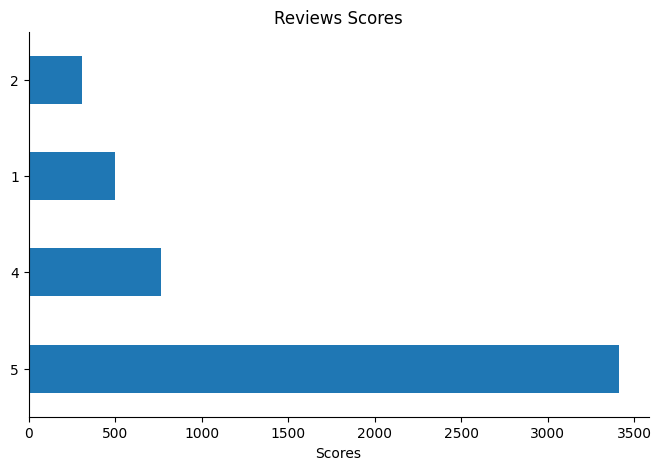

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

df['Score'].value_counts()\
    .plot(kind='barh', 
          title='Reviews Scores', 
          figsize=(8, 5))
plt.xlabel('Scores')
ax.spines[['right', 'top']].set_visible(False)
#plt.savefig('/content/drive/MyDrive/DS/ВКР/NLP/Scors_Bar.jpeg')
plt.show()

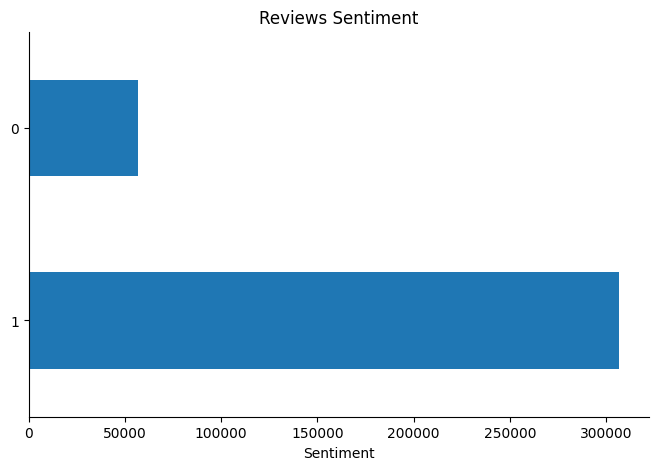

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

df_try['Sentiment'].value_counts()\
    .plot(kind='barh', 
          title='Reviews Sentiment', 
          figsize=(8, 5))
plt.xlabel('Sentiment')
ax.spines[['right', 'top']].set_visible(False)
#plt.savefig('/content/drive/MyDrive/Sentiment_Bar.jpeg')
plt.show()

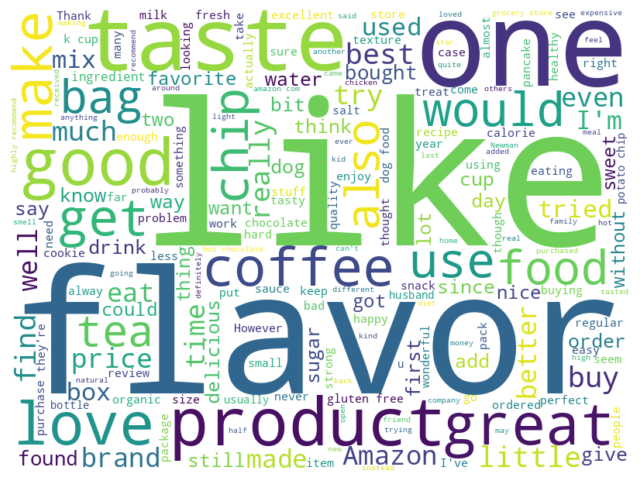

In [ ]:
# Create a word cloud of the 'Text' column
text = ' '.join(df['Text'].astype(str).tolist())
wordcloud = WordCloud(
    width=800, 
    height=600, 
    background_color='white').generate(text) # stopwords=stopwords1
    
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
#plt.savefig('/content/drive/MyDrive/DS/ВКР/NLP/wordcloud_gen.jpeg')
plt.show()

### Stopwords

In [ ]:
df = df[df['Score'] != 3]
df['Sentiment'] = df['Score'].apply(lambda rating : +1 if rating > 3 else 0)
df.drop(columns='Id', inplace=True)
df.head()

<ipython-input-290-e6a99159bef9>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-290-e6a99159bef9>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Score,Text,Sentiment
0,5,I have bought several of the Vitality canned d...,1
1,1,Product arrived labeled as Jumbo Salted Peanut...,0
2,4,This is a confection that has been around a fe...,1
3,2,If you are looking for the secret ingredient i...,0
4,5,Great taffy at a great price. There was a wid...,1


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/df_sent.csv', index_col='Unnamed: 0')
df.head()

,Score,Text,Sentiment
0,5,I have bought several of the Vitality canned d...,1
1,1,Product arrived labeled as Jumbo Salted Peanut...,0
2,4,This is a confection that has been around a fe...,1
3,2,If you are looking for the secret ingredient i...,0
4,5,Great taffy at a great price. There was a wid...,1


In [ ]:
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [ ]:
stop_words = stopwords.words('english')
stop_words.extend(['br', 'href'])

In [ ]:
print(pd.DataFrame(stop_words))

            0
0           i
1          me
2          my
3      myself
4          we
..        ...
176     won't
177    wouldn
178  wouldn't
179        br
180      href

[181 rows x 1 columns]


In [ ]:
# Create preprocess with stemming
#def df_preprocess_stem(text):
    text = text.lower()
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', 'site', text)
    text = re.sub('@[^\s]+', 'user', text)
    text = re.sub('[^а-яА-яa-zA-Z ]', ' ', text)
    stemmer = SnowballStemmer("english")
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])
    return text

In [ ]:
print(df['Text'][25])
%time print(df_preprocess_stem(df['Text'][25]))

Product received is as advertised.<br /><br /><a href="http://www.amazon.com/gp/product/B001GVISJM">Twizzlers, Strawberry, 16-Ounce Bags (Pack of 6)</a>
product receiv advertis site strawberri ounc bag pack
CPU times: user 954 µs, sys: 0 ns, total: 954 µs
Wall time: 1.05 ms


In [ ]:
# Create preprocess with lemmatization
def df_preprocess_lemma(text):
    text = text.lower()
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', 'site', text)
    text = re.sub('@[^\s]+', 'user', text)
    text = re.sub('[^а-яА-яa-zA-Z ]', ' ', text)
    wnl = WordNetLemmatizer()
    text = ' '.join([wnl.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

In [ ]:
print(df['Text'][25])
%time print(df_preprocess_lemma(df['Text'][25]))

Product received is as advertised.<br /><br /><a href="http://www.amazon.com/gp/product/B001GVISJM">Twizzlers, Strawberry, 16-Ounce Bags (Pack of 6)</a>
product received advertised site strawberry ounce bag pack
CPU times: user 849 µs, sys: 0 ns, total: 849 µs
Wall time: 860 µs


In [ ]:
# Create preprocessing for VADER and RoBERTa
def df_preprocess_sent(text):
    text = re.sub('br', ' ', text)
    text = re.sub('href', ' ', text)
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', 'site', text)
    text = re.sub('@[^\s]+', 'user', text)
    return text

In [ ]:
df['Text'].iloc[25]

'Product received is as advertised.<br /><br /><a href="http://www.amazon.com/gp/product/B001GVISJM">Twizzlers, Strawberry, 16-Ounce Bags (Pack of 6)</a>'

In [ ]:
df['Text'].iloc[575]

"I got the sea salt and vinegar chips from Kettle.  I am used to the Salt and Vinegar chips in the white bag if I am allowed to say that.  Anyways, my first impression for this is wow at all the chips you get for the price.  I got the 9 0z x 12 bags and wow it is so many for the price.  You can tell they are high quality chips just from the packaging, also.  Well being used to the cheaper chips I wasn't expecting how mellow these things are.  The ones I am used to have a really sour taste to them which I didn't mind but they had tons of flavor.  These chips don't have any sour to them at all, and taste just like them but a lot less strong aftertaste.  If you want to try out Salt and Vinegar chips I suggest you try these out first.  So, for the price and how many you get, these chips are definately worth it.  They are thick and crunchy like the more expensive chips you get at high quality restaurants.  I recommend these, 4 stars."

In [ ]:
df['Text'] = df['Text'].apply(df_preprocess_lemma)

In [ ]:
df['Text'].iloc[25]

'product received advertised site strawberry ounce bag pack'

In [ ]:
df['Text'].iloc[575]

'got sea salt vinegar chip kettle used salt vinegar chip white bag allowed say anyways first impression wow chip get price got z x bag wow many price tell high quality chip packaging also well used cheaper chip expecting mellow thing one used really sour taste mind ton flavor chip sour taste like lot le strong aftertaste want try salt vinegar chip suggest try first price many get chip definately worth thick crunchy like expensive chip get high quality restaurant recommend star'

In [ ]:
df.tail()

,Score,Text,Sentiment
5422,2,baby seem dinner tried terrible good either st...,0
5423,4,great organic baby food option delivered doors...,1
5424,5,little guy love try new food variety pack grea...,1
5425,2,ordered earth best nd dinner variety pack alon...,0
5426,1,baby love food whole food sell flat thats reta...,0


In [ ]:
#df_preprocessed = df.to_csv('/content/drive/MyDrive/df_preprocessed.csv')

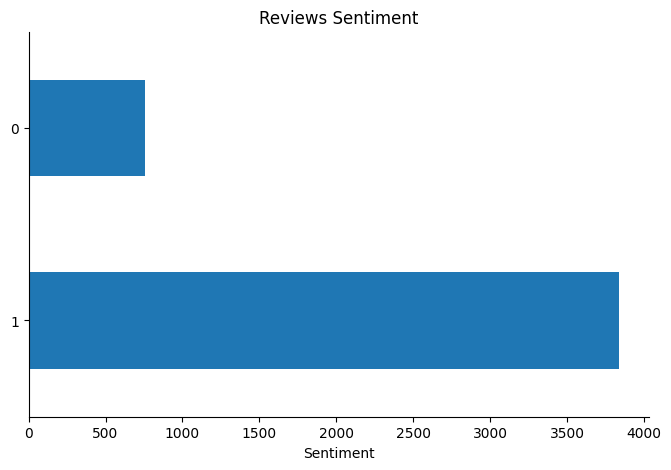

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

df['Sentiment'].value_counts()\
    .plot(kind='barh', 
          title='Reviews Sentiment', 
          figsize=(8, 5))
plt.xlabel('Sentiment')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig('/content/drive/MyDrive/Sentiment_Bar.jpeg')
plt.show()

# Rewies Classification

## Train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df['Text'], df['Sentiment'], 
                                                    train_size=0.75, test_size=0.25,
                                                    random_state=73)

In [ ]:
type(X_train)

pandas.core.frame.DataFrame

In [ ]:
X_train

In [ ]:
y_train

## BOW

In [ ]:
vectorizer = CountVectorizer(stop_words="english")

In [ ]:
X_train_BOW = vectorizer.fit_transform(X_train)
X_test_BOW = vectorizer.transform(X_test)

In [ ]:
print(X_train_BOW.shape, X_test_BOW.shape)

(3738, 9761) (1247, 9761)


In [ ]:
X_train.iloc[100]

'plan making pitcher tea forget take pack oz still weak must consumed hour say much better brewing however idea stash purse lady pocket men would weird okay one packet little flavor oz water use two drink oz water eat something nature also packet raspberry pom box give oz drink sure worth rather drink lemon water equally bland free'

In [ ]:
X_train_BOW[100]

<1x9761 sparse matrix of type '<class 'numpy.int64'>'
	with 38 stored elements in Compressed Sparse Row format>

## TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(stop_words="english")

In [ ]:
X_train_TFIDF = vectorizer.fit_transform(X_train)
X_test_TFIDF = vectorizer.transform(X_test)

In [ ]:
print(X_train_TFIDF.shape, X_test_TFIDF.shape)

(3738, 9761) (1247, 9761)


In [ ]:
X_train_TFIDF[100]

<1x9761 sparse matrix of type '<class 'numpy.float64'>'
	with 38 stored elements in Compressed Sparse Row format>

## BOW with bigram

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1, 2))

X_train_BOW_bi = vectorizer.fit_transform(X_train)
X_test_BOW_bi = vectorizer.transform(X_test)

print(X_train_BOW_bi.shape, X_test_BOW_bi.shape)

(3738, 104468) (1247, 104468)


## GaussianNB

In [ ]:
#BOW
nb = GaussianNB()
result_bayes = nb.fit(X_train_BOW.toarray(), y_train)
y_pred_BOW = result_bayes.predict(X_test_BOW.toarray())
accuracy_score(y_pred_BOW, y_test)

0.6663993584603047

In [ ]:
#TF-IDF
result_bayes = nb.fit(X_train_TFIDF.toarray(), y_train)
y_pred_TFIDF = result_bayes.predict(X_test_TFIDF.toarray())
accuracy_score(y_pred_TFIDF, y_test)


0.6663993584603047

In [ ]:
#BOW-bigram
result_bayes = nb.fit(X_train_BOW_bi.toarray(), y_train)
y_predict_BOW_bi = result_bayes.predict(X_test_BOW_bi.toarray())
accuracy_score(y_predict_BOW_bi, y_test)

0.8492381716118684

## Logistic Regression

In [ ]:
#BOW
logreg = LogisticRegression()
result_logreg = logreg.fit(X_train_BOW, y_train)
y_pred_BOW = result_logreg.predict(X_test_BOW)
accuracy_score(y_pred_BOW, y_test)

0.8957497995188453

In [ ]:
#TF-IDF
result_logreg = logreg.fit(X_train_TFIDF, y_train)
y_pred_TFIDF = result_logreg.predict(X_test_TFIDF)
accuracy_score(y_pred_TFIDF, y_test)

0.8588612670408982

In [ ]:
#BOW-bigram
result_logreg = logreg.fit(X_train_BOW_bi, y_train)
y_predict_BOW_bi = result_logreg.predict(X_test_BOW_bi)
accuracy_score(y_predict_BOW_bi, y_test)

0.8877305533279871

## SVM

In [ ]:
#BOW
metodsvm = svm.SVC()
result_svm = metodsvm.fit(X_train_BOW, y_train)
y_pred_BOW =  result_svm.predict(X_test_BOW)
accuracy_score(y_pred_BOW, y_test)

0.8540497193263833

In [ ]:
#TF-IDF
result_svm = metodsvm.fit(X_train_TFIDF, y_train)
y_pred_TFIDF = result_svm.predict(X_test_TFIDF)
accuracy_score(y_pred_TFIDF, y_test)

0.8604651162790697

In [ ]:
#BOW-bigram
result_svm = metodsvm.fit(X_train_BOW_bi, y_train)
y_predict_BOW_bi = result_svm.predict(X_test_BOW_bi)
accuracy_score(y_predict_BOW_bi, y_test)

0.8476343223736968

### Hyperparameters for LogReg. Cross-validation

In [ ]:
lsvc = LinearSVC(C = .5) # C = 0.5
selective_model = SelectFromModel(lsvc,  max_features  = None)

X_train_BOW_select_features = selective_model.fit_transform(X_train_BOW, y_train)
X_test_BOW_select_features = selective_model.transform(X_test_BOW)
print('\nNew shapes: ', X_train_BOW.shape, X_test_BOW.shape)
print('\nNew shapes: ', X_train_BOW_select_features.shape, X_test_BOW_select_features.shape)


New shapes:  (3738, 9761) (1247, 9761)

New shapes:  (3738, 3096) (1247, 3096)


In [ ]:
logreg = LogisticRegression(random_state=73)
scores_cvs = cross_val_score(logreg, X_train_BOW_select_features, y_train, cv=3, scoring='accuracy')
print(logreg,'\n Cross-validate: ', scores_cvs)

LogisticRegression(random_state=73) 
 Cross-validate:  [0.89727127 0.88764045 0.89486356]


In [ ]:
logreg = LogisticRegression(random_state=73).fit(X_train_BOW_select_features, y_train)
y_predict_BOW = logreg.predict(X_test_BOW_select_features)
accuracy_score(y_predict_BOW, y_test)

0.888532477947073

In [ ]:
#BOW
logreg = LogisticRegression()
result_logreg = logreg.fit(X_train_BOW, y_train)
y_pred_BOW = result_logreg.predict(X_test_BOW)
accuracy_score(y_pred_BOW, y_test)

### Hyperparameters for LogReg. Grid search

In [ ]:
grid={
      'C':np.logspace(-3,3,4), 
      'penalty':['l1', 'l2'],
      "solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
      }

logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=3)
%time logreg_cv.fit(X_train_BOW_select_features, y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.9/dist-packages/sklearn

CPU times: user 30.8 s, sys: 2.85 ms, total: 30.8 s
Wall time: 31 s
tuned hpyerparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2', 'solver': 'sag'}
accuracy : 0.8972712680577849


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [ ]:
logreg_cv.best_params_

{'C': 10.0, 'penalty': 'l2', 'solver': 'sag'}

In [ ]:
logreg = LogisticRegression(C=10.0, penalty='l2', solver='sag').fit(X_train_BOW_select_features, y_train)
y_predict_BOW = logreg.predict(X_test_BOW_select_features)
accuracy_score(y_predict_BOW, y_test)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



0.8989574979951884